In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')

In [35]:
import gpflow

In [4]:
import sys
sys.path.append('../code')
from dgp import DGP

gpflow.config.set_default_summary_fmt('notebook')
np.random.seed(0)
tf.random.set_seed(0)

## Generating data

In [5]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

N = 10000  # Number of training observations

X = rnd.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rnd.randn(N, 1)  # Noisy Y values
data = (X, Y)

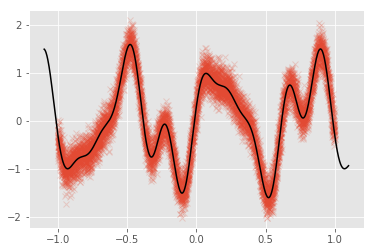

In [6]:
plt.plot(X, Y, 'x', alpha=0.2)
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k');

## Building model (single SVGP and DGP)

In [7]:
M = 50  # Number of inducing locations

kernel = gpflow.kernels.SquaredExponential()
Z = X[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset

m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

In [15]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = gpflow.kernels.SquaredExponential(variance=1, lengthscale=0.2)\
            + gpflow.kernels.White(variance=1e-5)
        kernels.append(k)
        
    m_dgp = DGP(X.shape[1], kernels, gpflow.likelihoods.Gaussian(), 
                Z, num_outputs=Y.shape[1],
                num_samples=100, num_data=N)
    
#     Initialise the layers to near deterministic
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = gpflow.base.Parameter(layer.q_sqrt.value() * 1e-5, 
                                 transform=gpflow.utilities.triangular())
        
    return m_dgp

dgp = make_DGP(2)

## Likelihood computation: batch vs. minibatch

In [8]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [53]:
dgp_ll = tf.function(autograph=False)(dgp.log_likelihood)

In [9]:
%%timeit
log_likelihood(data)

21.3 ms ± 881 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%%timeit
dgp_ll(*data,full_cov=False)

4.23 s ± 234 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X,Y)).repeat().shuffle(N)
train_it = iter(train_dataset.batch(minibatch_size))
ground_truth = m.log_likelihood(data).numpy()

In [55]:
ground_truth_dgp = dgp.log_likelihood(*data,full_cov=False).numpy()

In [13]:
%%timeit
log_likelihood(next(train_it))

1.4 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
dgp_ll(*next(train_it),full_cov=False)

48.7 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Stochastical esitimation of ELBO
The minibatch estimate should be an unbiased estimator of the ground_truth.
Histogram of different evaluations, together with mean and ground truth is shown.

In [21]:
evals = [log_likelihood(minibatch).numpy()
        for minibatch in itertools.islice(train_it,100)]

Discrepancy between ground truth and minibatch estimate: -18.751235092677234


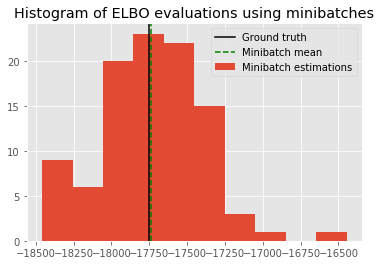

In [26]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [57]:
dgp_evals = [dgp_ll(*minibatch,full_cov=False).numpy()
            for minibatch in itertools.islice(train_it,100)]

Discrepancy between ground truth and minibatch estimate: 7.949924134420257


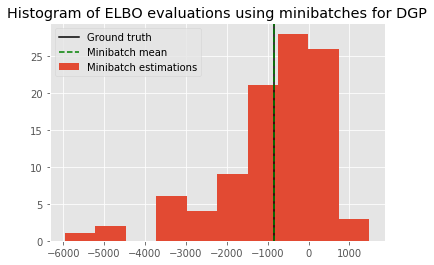

In [58]:
plt.hist(dgp_evals, label='Minibatch estimations')
plt.axvline(ground_truth_dgp, c='k', label='Ground truth')
plt.axvline(np.mean(dgp_evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches for DGP')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth_dgp - np.mean(dgp_evals))

## Running stochastic optimization

In [29]:
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)
for layer in dgp.layers:
    gpflow.utilities.set_trainable(layer.inducing_points.Z, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model:gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

@tf.function(autograph=False)
def optimization_step_dgp(optimizer, model:dgp, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch,full_cov=False)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations, opt_step_function):
    """
    Utility function running the Adam optimizer
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = - opt_step_function(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

Text(0.5,1,'ELBO of single layer SVGP')

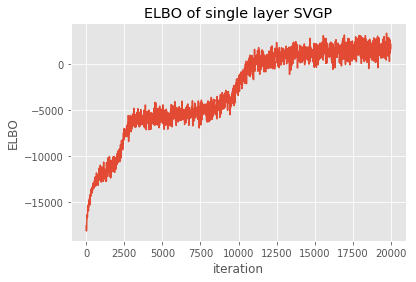

In [30]:
maxiter = ci_niter(20000)

logf = run_adam(m, maxiter, optimization_step)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of single layer SVGP')

Text(0.5,1,'ELBO of DGP')

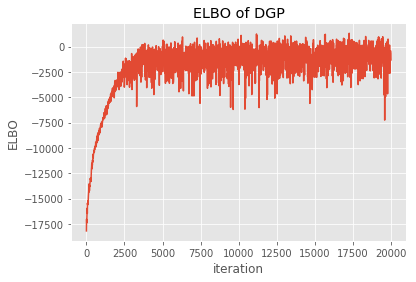

In [31]:
maxiter = ci_niter(20000)

logf = run_adam(dgp, maxiter, optimization_step_dgp)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of DGP')

In [51]:
def plot(title=''):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    pX = np.linspace(-1, 1, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')
    
def plot_dgp(title=''):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    pX = np.linspace(-1, 1, 100)[:, None]  # Test locations
    pY, pYv = dgp.predict_y(pX, 100, full_cov=False)
    #num of samples is 100, and mean and variance of MC samples are following
    #not very sure about this part
    pY = np.average(pY,0)
    pYv = np.average(pYv,0)
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = dgp.layers[0].inducing_points.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')

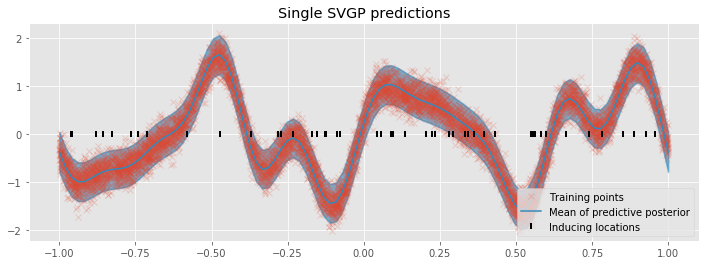

In [33]:
plot("Single SVGP predictions")

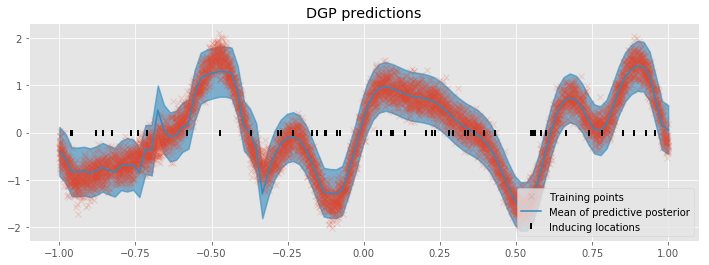

In [52]:
plot_dgp("DGP predictions")